# pipeline

0. read data
1. functions
    * general imformations
    * evaluation functions
    * set of functions
        * general goals
        * DIP functions

2. simple tests
    * pure wiener
    * pure sharp filter
    * combinations
        * canny + wiener
        * canny + sharp filter

3. iterative model
    * function implementation
    * improve with different image difference function



# imports

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
from scipy.signal import convolve2d
from skimage import feature,restoration
import pickle

#0. read data

next block should run just first time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive'
%cd 'MyDrive'

/content/drive
/content/drive/MyDrive


In [ ]:
!pwd

/content/drive/MyDrive


In [ ]:
# !wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/TrainIJCNN2013.zip
# !unzip TrainIJCNN2013.zip
# !rm TrainIJCNN2013.zip

In [ ]:
!ls | grep Train

TrainIJCNN2013


In [ ]:
filenames = os.listdir('TrainIJCNN2013')

In [ ]:
len(filenames)

646

In [ ]:
samplesnames = filenames[0::5]
samplesnames = ['TrainIJCNN2013/'+i for i in samplesnames]
print('#:',len(samplesnames),'\nexaple name:',samplesnames[0])

#: 130 
exaple name: TrainIJCNN2013/00005.ppm


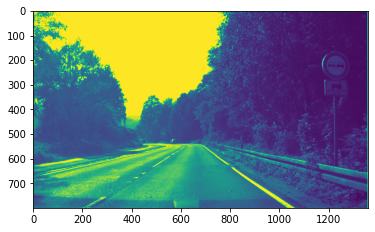

In [ ]:
sampleim = cv2.imread(samplesnames[0],cv2.IMREAD_GRAYSCALE)
plt.imshow(sampleim)

In [ ]:
ims = []
for name in tqdm(samplesnames[:]):
    im = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    # 
    try:
        if im.shape != (800, 1360):
            print(im.shape,type(im))
        else:
            ims.append(np.copy(im))
    except:
        pass
ims = np.array(ims)
print('\n-----------------------------------------\nshape:',ims.shape,
      '\n------------------------------------------\n# samples:',ims.shape[0],'\nsample shape:',ims.shape[1:])

100%|██████████| 130/130 [00:05<00:00, 23.71it/s]


-----------------------------------------
shape: (120, 800, 1360) 
------------------------------------------
# samples: 120 
sample shape: (800, 1360)


#1. functions

## general informations:

In [ ]:
info = {"imsshape": ims.shape,
        "lenims"  : ims.shape[0],
        "imshape" : ims.shape[1:],
        "imsize"  : ims.shape[1]*ims.shape[2]}
info

{'imsshape': (120, 800, 1360),
 'lenims': 120,
 'imshape': (800, 1360),
 'imsize': 1088000}

## evaluation functions


lets note:

for similarity between (img1,img2):
* compare images
    * simple mode: **compare_image**
    * **compare_boolean_image**
        * usage example: **edge_similarity**

image attributes:
* **varofimage**
* **varoflaplace**

In [ ]:
def varofimage(img):
    return img.var()

In [ ]:
def varoflaplace(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [ ]:
def edge_similarity(img1,img2,sigma=3):
    edge1 = feature.canny(img1,sigma=sigma)
    edge2 = feature.canny(img2,sigma=sigma)
    return compare_boolean_image(edge1,edge2,imsize=1088000)

## general goal *functions*

In [ ]:
def imshower(img):
    fig = plt.imshow(img);
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
def normalizer(img,max_=1):
    mi = img.min()
    img -= mi
    ma = img.max()
    img = img / ma
    img = img * max_
    return img

In [ ]:
def compare_image(img1,img2,imsize=1088000):
    return round(100*np.abs(img1-img2).sum()/imsize,2)

In [ ]:
def compare_boolean_image(img1,img2,imsize=1088000):
    return round(100*(img1==img2).sum()/imsize,2)

##DIP specific functions

1. wiener
2. canny
3. ...

In [ ]:
def wiener(img,kernel,if_unsupervised=True,supervised_regullizer_parameter=1100):
    if if_unsupervised:
        deconvolved, _ = restoration.unsupervised_wiener(img, kernel)
    else:
        deconvolved = restoration.wiener(img, kernel, supervised_regullizer_parameter)
    return deconvolved

below functions are just for remembrance, we will use inner part of them directly to recieve lower time consuming

In [ ]:
def canny(img,sigma=3):
    feature.canny(img,sigma=sigma)

In [ ]:
def img_sharpenning(img,kernel=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])):
    return convolve2d(img,kernel,'same')

In [ ]:
def blurrer(img,kernel=np.array([[1,1,1],[1,1,1],[1,1,1]])/9):
    return convolve2d(img,kernel,'same')

# 2. simple tests

In [ ]:
info

{'imsshape': (120, 800, 1360),
 'lenims': 120,
 'imshape': (800, 1360),
 'imsize': 1088000}

pure wiener

In [ ]:
wlogs = {}

wlogs['original_var'] = np.zeros(info['lenims'])
wlogs['original_lap_var'] = np.zeros(info['lenims'])
wlogs['blur_var'] = np.zeros(info['lenims'])
wlogs['blur_lap_var'] = np.zeros(info['lenims'])
wlogs['wiener_var'] = np.zeros(info['lenims'])
wlogs['wiener_lap_var'] = np.zeros(info['lenims'])
wlogs['blur&original similarity'] = np.zeros(info['lenims'])
wlogs['wiener&original similarity'] = np.zeros(info['lenims'])
wlogs['blur&original edge similarity'] = np.zeros(info['lenims'])
wlogs['wiener&original edge similarity'] = np.zeros(info['lenims'])

wiener_ims = []

for c, im_c in tqdm(enumerate(ims)):
    #original := im
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))

    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    #wiener : wsample
    wsample = wiener(bsample,kernel)
    wsample -=  wsample.min()
    wsample =  wsample/wsample.max()
    wiener_ims.append(wsample)

    wlogs['original_var'][c] = im.var()
    wlogs['original_lap_var'][c] = cv2.Laplacian(im, cv2.CV_64F).var()
    
    wlogs['blur_var'][c] = bsample.var()
    wlogs['blur_lap_var'][c] = cv2.Laplacian(bsample, cv2.CV_64F).var()
    
    wlogs['wiener_var'][c] = wsample.var()
    wlogs['wiener_lap_var'][c] = cv2.Laplacian(wsample, cv2.CV_64F).var()

    wlogs['blur&original similarity'][c] = compare_image(im,bsample)
    wlogs['wiener&original similarity'][c] = compare_image(im,wsample)
    edge_of_im = feature.canny(im)
    wlogs['blur&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(wsample))
    wlogs['wiener&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(bsample))

    # imshower(wsample)
    # imshower(feature.canny(wsample))
    # imshower(feature.canny(im))

120it [10:55,  5.46s/it]


In [ ]:
with open('wlogs.pickle', 'wb') as handle:
    pickle.dump(wlogs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('wlogs.pickle', 'rb') as handle:
    # wlogs = pickle.load(handle)

In [ ]:
with open('wiener_ims.pickle', 'wb') as handle:
    pickle.dump(wiener_ims, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('wiener_ims.pickle', 'rb') as handle:
    # wiener_ims = pickle.load(handle)

In [ ]:
# with open('wiener_ims.pickle', 'rb') as handle:
#     wiener_ims = pickle.load(handle)

In [ ]:
w_avg = {}

w_avg['blur_var']                        = round(np.average(wlogs['blur_var']),3)
w_avg['wiener_var']                      = round(np.average(wlogs['wiener_var']),3) 
w_avg['blur_lap_var']                    = round(np.average(wlogs['blur_lap_var']),3) 
w_avg['original_var']                    = round(np.average(wlogs['original_var']),3) 
w_avg['wiener_lap_var']                  = round(np.average(wlogs['wiener_lap_var']),3) 
w_avg['original_lap_var']                = round(np.average(wlogs['original_lap_var']),3) 
w_avg['blur&original similarity']        = round(np.average(wlogs['blur&original similarity']),3) 
w_avg['wiener&original similarity']      = round(np.average(wlogs['wiener&original similarity']),3) 
w_avg['blur&original edge similarity']   = round(np.average(wlogs['blur&original edge similarity']),3) 
w_avg['wiener&original edge similarity'] = round(np.average(wlogs['wiener&original edge similarity']),3) 

In [ ]:
w_avg

{'blur_var': 0.126,
 'wiener_var': 0.031,
 'blur_lap_var': 0.002,
 'original_var': 0.128,
 'wiener_lap_var': 0.005,
 'original_lap_var': 0.014,
 'blur&original similarity': 1.473,
 'wiener&original similarity': 17.011,
 'blur&original edge similarity': 96.516,
 'wiener&original edge similarity': 96.32}

pure sharp filter

In [ ]:
slogs = {}

slogs['sharp_var'] = np.zeros(info['lenims'])
slogs['sharp_lap_var'] = np.zeros(info['lenims'])
slogs['sharp&original similarity'] = np.zeros(info['lenims'])
slogs['sharp&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims)):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    
    #wiener : wsample
    shsample = img_sharpenning(bsample)
    shsample -= shsample.min()
    shsample = shsample/shsample.max()

    slogs['sharp_var'][c] = shsample.var()
    slogs['sharp_lap_var'][c] = cv2.Laplacian(shsample, cv2.CV_64F).var()
    slogs['sharp&original similarity'][c] = compare_image(im,shsample)

    edge_of_im = feature.canny(im)
    slogs['sharp&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(shsample))

120it [01:47,  1.11it/s]


In [ ]:
with open('slogs.pickle', 'wb') as handle:
    pickle.dump(slogs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
s_avg = {}

s_avg['sharp_var']                        = round(np.average(slogs['sharp_var']),3)
s_avg['sharp_lap_var']                    = round(np.average(slogs['sharp_lap_var']),3) 
s_avg['sharp&original similarity']        = round(np.average(slogs['sharp&original similarity']),3) 
s_avg['sharp&original edge similarity']        = round(np.average(slogs['sharp&original edge similarity']),3) 

In [ ]:
s_avg

{'sharp_var': 0.008,
 'sharp_lap_var': 0.003,
 'sharp&original similarity': 24.643,
 'sharp&original edge similarity': 95.755}

combinations of canny & wiener

In [ ]:
cwlogs = {}

cwlogs['cw_var'] = np.zeros(info['lenims'])
cwlogs['cw_lap_var'] = np.zeros(info['lenims'])
cwlogs['cw&original similarity'] = np.zeros(info['lenims'])
cwlogs['cwin&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims)):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    cwim = wim + feature.canny(bsample,sigma=3)
    cwim[cwim>1]=1
    cwim -= cwim.min()
    cwim = cwim/cwim.max()

    cwlogs['cw_var'][c] = cwim.var()
    cwlogs['cw_lap_var'][c] = cv2.Laplacian(cwim, cv2.CV_64F).var()
    cwlogs['cw&original similarity'][c] = compare_image(im,cwim)

    edge_of_im = feature.canny(im)
    cwlogs['cwin&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(cwim))

120it [02:19,  1.16s/it]


In [ ]:
cw_avg = {}

cw_avg['cw_var']                        = round(np.average(cwlogs['cw_var']),3)
cw_avg['cw_lap_var']                    = round(np.average(cwlogs['cw_lap_var']),3) 
cw_avg['cw&original similarity']        = round(np.average(cwlogs['cw&original similarity']),3) 
cw_avg['cwin&original edge similarity'] = round(np.average(cwlogs['cwin&original edge similarity']),3)

cw_avg

{'cw_var': 0.133,
 'cw_lap_var': 0.073,
 'cw&original similarity': 1.407,
 'cwin&original edge similarity': 95.225}

In [ ]:

cw2logs = {}

cw2logs['cw_var'] = np.zeros(info['lenims'])
cw2logs['cw_lap_var'] = np.zeros(info['lenims'])
cw2logs['cw&original similarity'] = np.zeros(info['lenims'])
cw2logs['cwin&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims)):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    cwim = wim + 0.5*feature.canny(bsample,sigma=3)
    cwim[cwim>1]=1
    cwim -= cwim.min()
    cwim = cwim/cwim.max()

    cw2logs['cw_var'][c] = cwim.var()
    cw2logs['cw_lap_var'][c] = cv2.Laplacian(cwim, cv2.CV_64F).var()
    cw2logs['cw&original similarity'][c] = compare_image(im,cwim)

    edge_of_im = feature.canny(im)
    cw2logs['cwin&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(cwim))

120it [02:19,  1.16s/it]


In [ ]:
cw2_avg = {}

cw2_avg['cw_var']                        = round(np.average(cw2logs['cw_var']),3)
cw2_avg['cw_lap_var']                    = round(np.average(cw2logs['cw_lap_var']),3) 
cw2_avg['cw&original similarity']        = round(np.average(cw2logs['cw&original similarity']),3) 
cw2_avg['cwin&original edge similarity'] = round(np.average(cw2logs['cwin&original edge similarity']),3)

cw2_avg

{'cw_var': 0.131,
 'cw_lap_var': 0.046,
 'cw&original similarity': 1.115,
 'cwin&original edge similarity': 95.53}

In [ ]:
with open('cwlogs.pickle', 'wb') as handle:
    pickle.dump(cwlogs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cw2logs.pickle', 'wb') as handle:
    pickle.dump(cw2logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('cw2logs.pickle', 'rb') as handle:
    cw2logs = pickle.load(handle)

In [ ]:
cw2logs.keys()

dict_keys(['cw_var', 'cw_lap_var', 'cw&original similarity', 'cwin&original edge similarity'])

In [ ]:
cw2_avg = {}

cw2_avg['cw_var']                        = round(np.average(cw2logs['cw_var']),3)
cw2_avg['cw_lap_var']                    = round(np.average(cw2logs['cw_lap_var']),3) 
cw2_avg['cw&original similarity']        = round(np.average(cw2logs['cw&original similarity']),3)
cw2_avg['cwin&original edge similarity']        = round(np.average(cw2logs['cwin&original edge similarity']),3) 


cw2_avg

{'cw_var': 0.131,
 'cw_lap_var': 0.046,
 'cw&original similarity': 1.115,
 'cwin&original edge similarity': 95.53}

#3. iterative model

In [ ]:
def loss1(current_image,kernel,blurred_image):
    temp = convolve2d(current_image, kernel,"same") - blurred_image
    return 0.5 * (temp**2).sum()

In [ ]:
def gradient(current_image,kernel,blurred_image):
    temp = convolve2d(current_image, kernel,'same')
    return convolve2d(temp - blurred_image, kernel.T,'same')

In [ ]:
im = ims[0].copy()
kernel = np.ones((3,3))/9
blurred_image = blurrer(im)  

In [ ]:
im = im/im.max()
blurred_image = blurred_image/blurred_image.max()

In [ ]:
g = gradient(im,kernel,blurred_image)

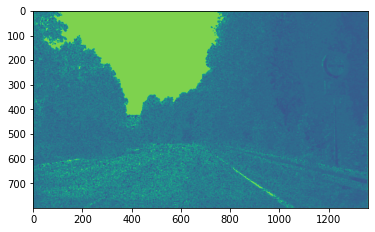

In [ ]:
plt.imshow(g);plt.show();

In [ ]:
def iterator(blurred_image,kernel,max_iter=500,least_loss=10,current_image=""):
    learning_rate = 0.01
    
    if current_image == "":
        current_image = np.copy(blurred_image)

    converge_flag = True
    iter = 1
    loss_list = []
    while(iter<=max_iter and converge_flag):
        if iter %50 == 0:
            print("interation number = ",iter)
            print(loss)

        iter += 1
        current_image -= learning_rate*gradient(current_image,kernel,blurred_image)
        
        loss = round(loss1(current_image,kernel,blurred_image),2)
        loss_list.append(loss)
        
        if loss<least_loss:
            converge_flag = False
    print(iter-1)
    return loss_list, current_image

In [ ]:
im = ims[0].copy()
kernel = np.ones((3,3))/9
blurred_image = blurrer(im)    
im = im/im.max()
blurred_image = blurred_image/blurred_image.max()


In [ ]:
loss_list, current_image = iterator(blurred_image,kernel,max_iter=500,least_loss=1)

interation number =  50
91.55
interation number =  100
66.91
interation number =  150
50.97
interation number =  200
40.22
interation number =  250
32.69
interation number =  300
27.22
interation number =  350
23.12
interation number =  400
19.97
interation number =  450
17.49
interation number =  500
15.49
500


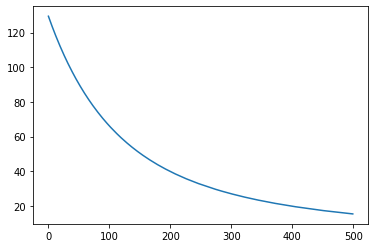

In [ ]:
plt.plot(loss_list)

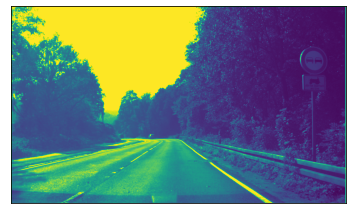

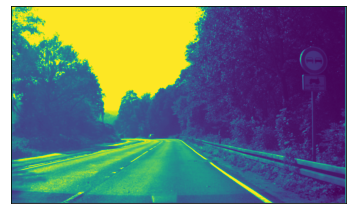

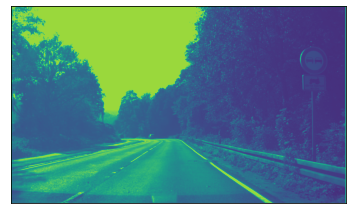

In [ ]:
imshower(im)
imshower(blurred_image)
imshower(current_image)

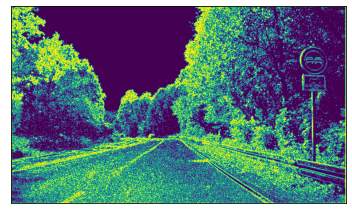

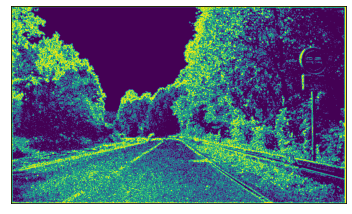

In [ ]:
# imshower(im)
temp = abs(blurred_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)

In [ ]:
cwlogs = {}

cwlogs['cw_var'] = np.zeros(info['lenims'])
cwlogs['cw_lap_var'] = np.zeros(info['lenims'])
cwlogs['cw&original similarity'] = np.zeros(info['lenims'])
cwlogs['cwin&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims[:1])):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    cwim = wim + feature.canny(bsample,sigma=3)
    cwim[cwim>1]=1
    cwim -= cwim.min()
    cwim = cwim/cwim.max()

    l1,current_image1 = iterator(np.copy(bsample),kernel,max_iter=100,least_loss=1)
    l2,current_image_cwim = iterator(np.copy(bsample),kernel,max_iter=100,least_loss=1,current_image=cwim)
    
    print(l1[-1])
    print(l2[-1])


0it [00:00, ?it/s]

interation number =  50
1.93
69


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


interation number =  50
207.23


1it [00:26, 26.95s/it]

interation number =  100
76.23
100
0.97
75.17


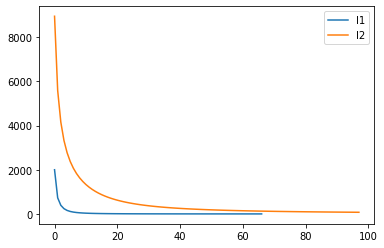

In [ ]:
plt.plot(l1[2:], label = 'l1')
plt.plot(l2[2:], label = 'l2')
plt.legend()
plt.show()

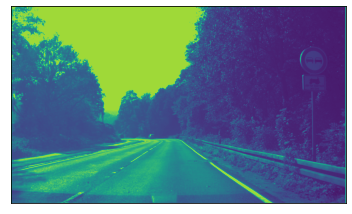

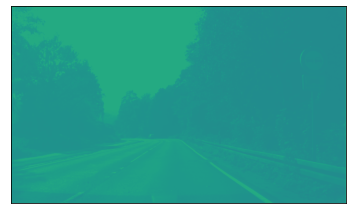

In [ ]:
imshower(current_image1)
imshower(current_image_cwim)

#4. eddited iterative model

**edge based model**

In [ ]:
def iterator2(blurred_image,edge_image,kernel,max_iter=500,least_loss=10):
    learning_rate = 0.01

    current_image = np.copy(blurred_image)

    converge_flag = True
    iter = 1
    loss_list = []
    edge_active = True
    while(iter<=max_iter and converge_flag):
        if iter %50 == 0:
            print("interation number = ",iter)
            print(loss)

        iter += 1
        if edge_active:
            current_image += 0.004*edge_image
        
        current_image -= learning_rate*gradient(current_image,kernel,blurred_image)
        
        lossedge = round(loss1(current_image+ 0.004*edge_image,kernel,blurred_image),2)
        loss = round(loss1(current_image,kernel,blurred_image),2)
        
        edge_active = True
        if loss<lossedge:
            edge_active = False
        else:
            loss = lossedge

        loss_list.append(loss)
        
        if loss<least_loss:
            converge_flag = False

    print(iter-1)
    return loss_list, current_image

In [ ]:
im = ims[0].copy()
kernel = np.ones((3,3))/9
blurred_image = blurrer(im)    
im = im/im.max()
blurred_image = blurred_image/blurred_image.max()


In [ ]:
edge = feature.canny(blurred_image,sigma=3)
loss_list, current_image = iterator2(blurred_image,edge_image=edge,kernel=kernel,max_iter=600,least_loss=1)

interation number =  50
91.66
interation number =  100
67.06
interation number =  150
51.13
interation number =  200
40.38
interation number =  250
32.83
interation number =  300
27.35
interation number =  350
23.24
interation number =  400
20.07
interation number =  450
17.58
interation number =  500
15.57
interation number =  550
13.92
interation number =  600
12.55
600


In [ ]:
edge = feature.canny(blurred_image)
loss_list2, current_image2 = iterator2(blurred_image,edge,kernel,max_iter=600,least_loss=1)

interation number =  50
91.55
interation number =  100
67.22
interation number =  150
51.41
interation number =  200
40.7
interation number =  250
33.16
interation number =  300
27.66
interation number =  350
23.53
interation number =  400
20.35
interation number =  450
17.83
interation number =  500
15.8
interation number =  550
14.13
interation number =  600
12.74
600


In [ ]:
loss_list3, current_image3 = iterator(blurred_image,kernel=kernel,max_iter=600,least_loss=1)

interation number =  50
91.55
interation number =  100
66.91
interation number =  150
50.97
interation number =  200
40.22
interation number =  250
32.69
interation number =  300
27.22
interation number =  350
23.12
interation number =  400
19.97
interation number =  450
17.49
interation number =  500
15.49
interation number =  550
13.85
interation number =  600
12.48
600


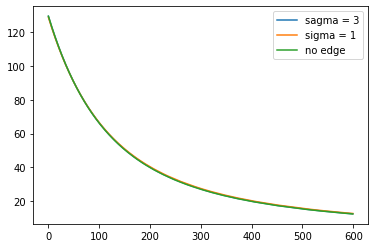

In [ ]:
plt.plot(loss_list,label="sagma = 3")
plt.plot(loss_list2,label="sigma = 1")
plt.plot(loss_list3,label="no edge")
plt.legend()
plt.show()

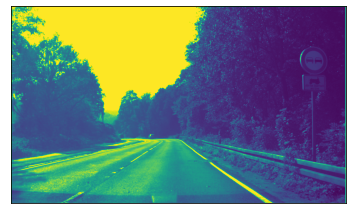

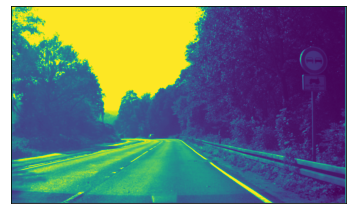

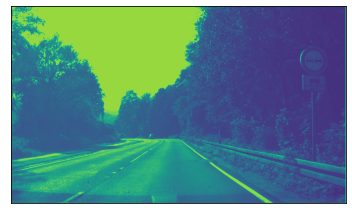

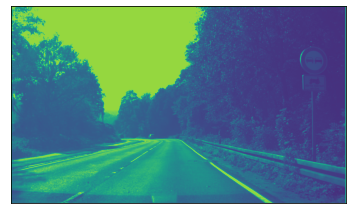

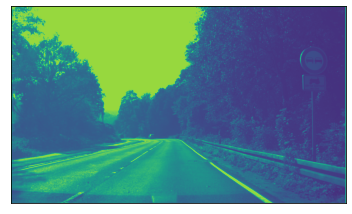

In [ ]:
imshower(im)
imshower(blurred_image)
imshower(current_image)
imshower(current_image2)
imshower(current_image3)


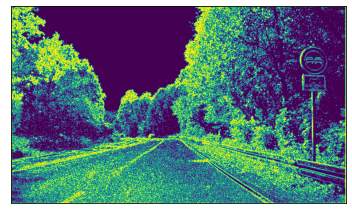

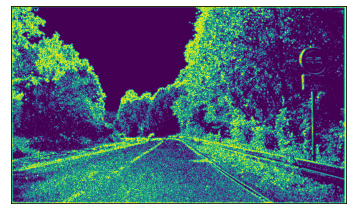

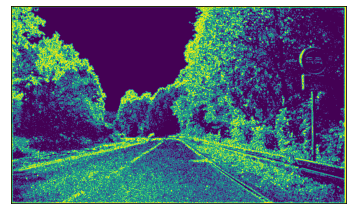

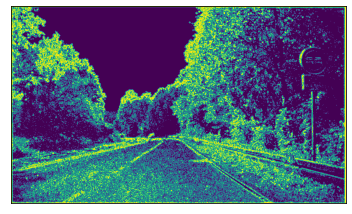

In [ ]:
# imshower(im)
temp = abs(blurred_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image2-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image3-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)

In [ ]:
for c, im_c in tqdm(enumerate(ims[:1])):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    

    l1,current_image1 = iterator(np.copy(bsample),kernel,max_iter=100,least_loss=10)
    l2,current_image_cwim = iterator2(np.copy(bsample),edge,kernel,max_iter=100,least_loss=1)
    
    print(l1[-1])
    print(l2[-1])


0it [00:00, ?it/s]

23
interation number =  50
2.02


1it [00:19, 19.80s/it]

71
9.82
0.97


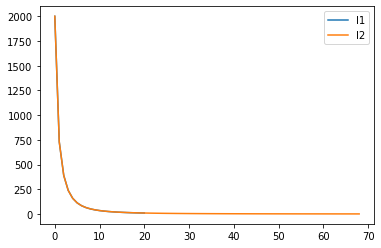

In [ ]:
plt.plot(l1[2:], label = 'l1')
plt.plot(l2[2:], label = 'l2')
plt.legend()
plt.show()

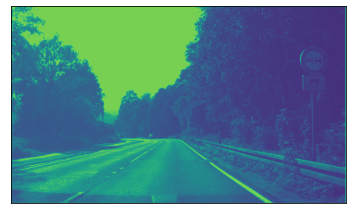

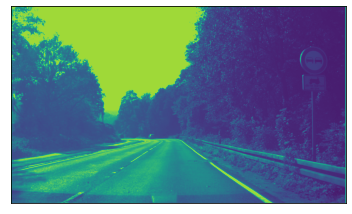

In [ ]:
imshower(current_image1)
imshower(current_image_cwim)

#Deep method:

In [ ]:
ims.max(),ims.min()

(255, 2)

In [ ]:
ims.shape

(120, 800, 1360)

In [ ]:
blur_kernel = np.ones((3,3))/9

bls = []
for im in ims:
    fim = im.reshape(-1)
    b = convolve2d(im,blur_kernel,'same')
    bls.append(b)

In [ ]:
len(ims), len(ims[0])

(120, 800)

In [ ]:
xtrain = np.array(ims[:100])
xtest = np.array(ims[100:])
ytrain = np.array(bls[:100])
ytest = np.array(bls[100:])

In [ ]:
ims = []

In [ ]:
print(xtrain.max(),xtrain.min())
print(ytrain.max(),ytrain.min())
print(xtest.max(),xtest.min())
print(ytest.max(),ytest.min())

255 2
255.00000000000003 3.0
255 4
255.00000000000003 3.333333333333333


In [ ]:
ims = []

In [ ]:
ytrain.shape,xtrain.shape

((100, 800, 1360), (100, 800, 1360))

In [ ]:
xtrain = (xtrain / 255) - 0.5
xtest = (xtest / 255) - 0.5

ytrain = (ytrain / 255) - 0.5
ytest = (ytest / 255) - 0.5

In [ ]:
print(xtrain.max(),xtrain.min())
print(ytrain.max(),ytrain.min())
print(xtest.max(),xtest.min())
print(ytest.max(),ytest.min())

0.5 -0.49215686274509807
0.5000000000000002 -0.48823529411764705
0.5 -0.4843137254901961
0.5000000000000002 -0.4869281045751634


In [ ]:
xtrain = np.expand_dims(xtrain, axis=3)
xtest = np.expand_dims(xtest, axis=3)

ytrain = np.expand_dims(ytrain, axis=3)
ytest = np.expand_dims(ytest, axis=3)

print(xtrain.shape) # (60000, 28, 28, 1)
print(xtest.shape)  # (10000, 28, 28, 1)

(100, 800, 1360, 1)
(20, 800, 1360, 1)


In [ ]:
xtrain.max(),xtrain.min()

(0.5, -0.49215686274509807)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential

In [ ]:
# num_filters = 10
filter_size = 3

model2 = Sequential([
  Conv2D(4, filter_size, input_shape=(800, 1360, 1), padding="SAME"),
  Conv2D(1, filter_size, input_shape=(800, 1360, 1), padding="SAME"),
])

In [ ]:
model2.compile(
  optimizer="adam", loss="mean_squared_error"
)

In [ ]:
model2.fit(
  xtrain,
  ytrain,
  epochs=20,
  validation_data=(xtest, ytest),
)

Epoch 1/20
4/4 [==============================] - 54s 12s/step - loss: 0.1194 - val_loss: 0.1047
Epoch 2/20
4/4 [==============================] - 52s 12s/step - loss: 0.0952 - val_loss: 0.0817
Epoch 3/20
4/4 [==============================] - 54s 13s/step - loss: 0.0737 - val_loss: 0.0622
Epoch 4/20
4/4 [==============================] - 58s 14s/step - loss: 0.0557 - val_loss: 0.0457
Epoch 5/20
4/4 [==============================] - 53s 12s/step - loss: 0.0404 - val_loss: 0.0322
Epoch 6/20
4/4 [==============================] - 54s 13s/step - loss: 0.0281 - val_loss: 0.0216
Epoch 7/20
4/4 [==============================] - 52s 12s/step - loss: 0.0185 - val_loss: 0.0136
Epoch 8/20
4/4 [==============================] - 52s 12s/step - loss: 0.0113 - val_loss: 0.0080
Epoch 9/20
4/4 [==============================] - 54s 12s/step - loss: 0.0065 - val_loss: 0.0044
Epoch 10/20
4/4 [==============================] - 53s 13s/step - loss: 0.0035 - val_loss: 0.0025
Epoch 11/20
4/4 [============

In [ ]:
with open('model2.pickle', 'wb') as handle:
    pickle.dump(model2, handle, protocol=pickle.HIGHEST_PROTOCOL)

## model with 1 layer : simpler model:

In [ ]:
# num_filters = 10
filter_size = 3

model = Sequential([
  Conv2D(1, filter_size, input_shape=(800, 1360, 1), padding="SAME"),
])

In [ ]:
model.compile(
  optimizer="adam", loss="mean_squared_error"
)

In [ ]:
model.fit(
  xtrain,
  ytrain,
  epochs=60,
  validation_data=(xtest, ytest),
)

Epoch 1/60
4/4 [==============================] - 19s 4s/step - loss: 0.0790 - val_loss: 0.0776
Epoch 2/60
4/4 [==============================] - 20s 5s/step - loss: 0.0737 - val_loss: 0.0725
Epoch 3/60
4/4 [==============================] - 18s 4s/step - loss: 0.0688 - val_loss: 0.0676
Epoch 4/60
4/4 [==============================] - 18s 4s/step - loss: 0.0642 - val_loss: 0.0629
Epoch 5/60
4/4 [==============================] - 18s 4s/step - loss: 0.0598 - val_loss: 0.0586
Epoch 6/60
4/4 [==============================] - 18s 4s/step - loss: 0.0557 - val_loss: 0.0545
Epoch 7/60
4/4 [==============================] - 18s 4s/step - loss: 0.0517 - val_loss: 0.0506
Epoch 8/60
4/4 [==============================] - 18s 4s/step - loss: 0.0480 - val_loss: 0.0470
Epoch 9/60
4/4 [==============================] - 18s 4s/step - loss: 0.0445 - val_loss: 0.0435
Epoch 10/60
4/4 [==============================] - 18s 4s/step - loss: 0.0413 - val_loss: 0.0403
Epoch 11/60
4/4 [======================

In [ ]:
test_results = model.evaluate(xtest, ytest, verbose=1)
print(f'Test results - Loss: {test_results}')

1/1 [==============================] - 2s 2s/step - loss: 0.0011
Test results - Loss: 0.0010587209835648537


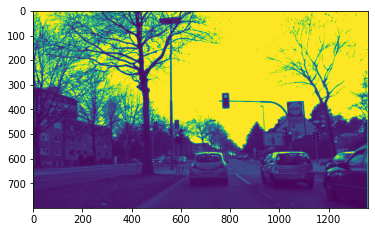

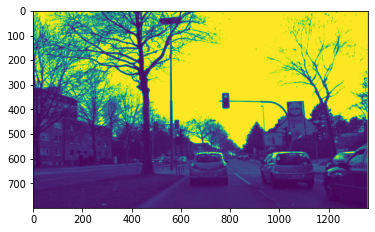

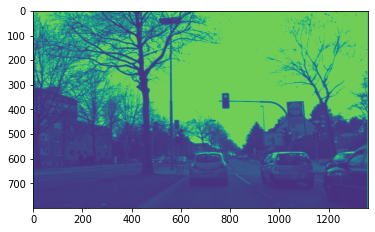

In [ ]:
sampleindex = 0
sample = xtest[sampleindex].reshape((1,800,1360,1))
out = model.predict(sample).reshape((800,1360))

plt.imshow(xtest[sampleindex].reshape((800,1360)));
plt.show();


plt.imshow(ytest[sampleindex].reshape((800,1360)));
plt.show();

plt.imshow(out);
plt.show();

In [ ]:
def compare_image(img1,img2,imsize=1088000):
    return round(100*np.abs(img1-img2).sum()/imsize,2)

In [ ]:
acc = []
for sampleindex in range(len(xtest)):   
    sample = xtest[sampleindex].reshape((1,800,1360,1))
    out = model.predict(sample).reshape((800,1360))
    acc.append(compare_image(out,ytest[sampleindex].reshape((800,1360)),imsize=1088000))

<BarContainer object of 20 artists>

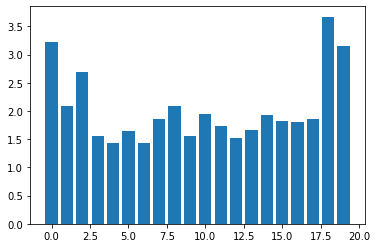

In [ ]:
plt.bar(range(len(acc)),acc)

In [ ]:
with open('model1.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### test above models:

#### one layer model:

In [ ]:
import cv2

In [ ]:
m1logs = {}
m1logs['var'] = np.zeros(20)
m1logs['lap_var'] = np.zeros(20)
m1logs['out&original similarity'] = np.zeros(20)
m1logs['out&original edge similarity'] = np.zeros(20)

for sampleindex in range(len(xtest)):   
    c = sampleindex
    sample = xtest[sampleindex].reshape((1,800,1360,1))
    out = model2.predict(sample).reshape((800,1360))
    
    # print(out.shape)

    out = out.astype("float64")
    sample = sample.reshape((800,1360))

    m1logs['var'][c] = out.var()
    m1logs['lap_var'][c] = cv2.Laplacian(out, cv2.CV_64F).var()


    m1logs['out&original similarity'][c] = compare_image(sample,out)

    edge_of_im = feature.canny(sample)
    m1logs['out&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(out))

In [ ]:
for i in m1logs.keys():
    print(i," : ",end="")
    print(round(np.average(m1logs[i]),3))

var  : 0.121
lap_var  : 0.011
out&original similarity  : 2.45
out&original edge similarity  : 91.764


In [ ]:
model2 = ''
with open('model1.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
m1logs = {}
m1logs['var'] = np.zeros(20)
m1logs['lap_var'] = np.zeros(20)
m1logs['out&original similarity'] = np.zeros(20)
m1logs['out&original edge similarity'] = np.zeros(20)

for sampleindex in range(len(xtest)):   
    c = sampleindex
    sample = xtest[sampleindex].reshape((1,800,1360,1))
    out = model.predict(sample).reshape((800,1360))
    
    # print(out.shape)

    out = out.astype("float64")
    sample = sample.reshape((800,1360))

    m1logs['var'][c] = out.var()
    m1logs['lap_var'][c] = cv2.Laplacian(out, cv2.CV_64F).var()


    m1logs['out&original similarity'][c] = compare_image(sample,out)

    edge_of_im = feature.canny(sample)
    m1logs['out&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(out))

In [ ]:
for i in m1logs.keys():
    print(i," : ",end="")
    print(round(np.average(m1logs[i]),3))

var  : 0.11
lap_var  : 0.014
out&original similarity  : 2.29
out&original edge similarity  : 94.782


#### iterative simple format test

In [ ]:
xtest -= xtest.min()
ytest -= ytest.min()


In [ ]:
len(xtest),xtest.max(),xtest.min(),ytest.max(),ytest.min()

(20, 0.9843137254901961, 0.0, 0.9869281045751637, 0.0)

In [ ]:
def loss1(current_image,kernel,blurred_image):
    temp = convolve2d(current_image, kernel,"same") - blurred_image
    return 0.5 * (temp**2).sum()

In [ ]:
def gradient(current_image,kernel,blurred_image):
    temp = convolve2d(current_image, kernel,'same')
    return convolve2d(temp - blurred_image, kernel.T,'same')

In [ ]:
def iterator(blurred_image,kernel,max_iter=500):
    
    current_image = blurred_image

   
    iter = 0
    while(iter<=max_iter):
        

        iter += 1
        learning_rate = min(0.01,1/iter)

        current_image -= learning_rate*gradient(current_image,kernel,blurred_image)

    return current_image

In [ ]:
i = 2
im = np.copy(xtest[i])
im = im.reshape((800, 1360))
blur = np.copy(ytest[i])
blur = blur.reshape((800, 1360))
kernel = np.ones((3,3))/9

temp = iterator(np.copy(blur),kernel,max_iter=3)


In [ ]:
ilogs = {}
ilogs['var'] = np.zeros(20)
ilogs['lap_var'] = np.zeros(20)
ilogs['out&original similarity'] = np.zeros(20)
ilogs['out&original edge similarity'] = np.zeros(20)


for i in tqdm(range(len(xtest))):
    im = np.copy(xtest[i])
    blur = np.copy(ytest[i])
    kernel = np.ones((3,3))/9
    
    blur = blur.reshape((800, 1360))
    im = im.reshape((800, 1360))

    out = iterator(np.copy(blur),kernel,max_iter=100)

    ilogs['var'][c] = out.var()
    ilogs['lap_var'][c] = cv2.Laplacian(out, cv2.CV_64F).var()

    ilogs['out&original similarity'][c] = compare_image(im,out)

    edge_of_im = feature.canny(im)
    ilogs['out&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(out))

100%|██████████| 20/20 [03:47<00:00, 11.37s/it]


In [ ]:
for i in m1logs.keys():
    print(i," : ",end="")
    print(round(np.average(ilogs[i]),3))

var  : 0.005
lap_var  : 0.001
out&original similarity  : 0.146
out&original edge similarity  : 4.695


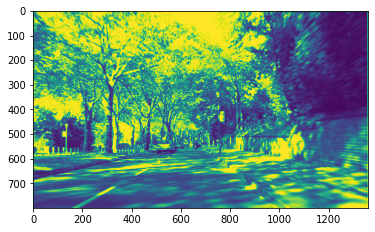

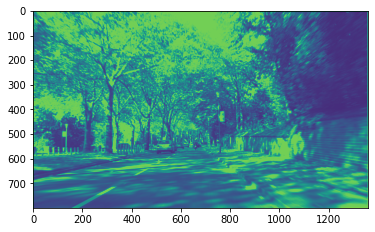

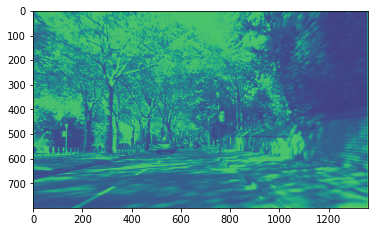

In [ ]:
plt.imshow(im);plt.show();
plt.imshow(blur);plt.show();
plt.imshow(out);plt.show();

In [ ]:
blogs = {}
blogs['var'] = np.zeros(20)
blogs['lap_var'] = np.zeros(20)
blogs['out&original similarity'] = np.zeros(20)
blogs['out&original edge similarity'] = np.zeros(20)


for i in tqdm(range(len(xtest))):
    im = xtest[i]
    blur = ytest[i]
    kernel = np.ones((3,3))/9
    
    blur = blur.reshape((800, 1360))
    im = im.reshape((800, 1360))

    

    blogs['var'][c] = blur.var()
    blogs['lap_var'][c] = cv2.Laplacian(blur, cv2.CV_64F).var()

    blogs['out&original similarity'][c] = compare_image(im,blur)

    edge_of_im = feature.canny(im)
    blogs['out&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(blur))

for i in m1logs.keys():
    print(i," : ",end="")
    print(round(np.average(blogs[i]),3))

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]

var  : 0.005
lap_var  : 0.0
out&original similarity  : 0.123
out&original edge similarity  : 4.722


In [ ]:
imoriginallogs = {}
imoriginallogs['var'] = np.zeros(20)
imoriginallogs['lap_var'] = np.zeros(20)
imoriginallogs['out&original similarity'] = np.zeros(20)
imoriginallogs['out&original edge similarity'] = np.zeros(20)


for i in tqdm(range(len(xtest))):
    im = xtest[i]
    sample = im
    kernel = np.ones((3,3))/9
    
    sample = sample.reshape((800, 1360))
    im = im.reshape((800, 1360))

    

    imoriginallogs['var'][c] = sample.var()
    imoriginallogs['lap_var'][c] = cv2.Laplacian(sample, cv2.CV_64F).var()

    imoriginallogs['out&original similarity'][c] = compare_image(im,sample)

    edge_of_im = feature.canny(im)
    imoriginallogs['out&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(sample))

for i in m1logs.keys():
    print(i," : ",end="")
    print(round(np.average(imoriginallogs[i]),3))

100%|██████████| 20/20 [00:17<00:00,  1.16it/s]

var  : 0.005
lap_var  : 0.002
out&original similarity  : 0.0
out&original edge similarity  : 5.0
